## Anonymized credit card transactions labeled as fraudulent or genuine

https://www.kaggle.com/mlg-ulb/creditcardfraud

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

#### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Inspiration
Identify fraudulent credit card transactions.Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

#### Acknowledgements

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

In [1]:
from pyforest import *

In [2]:
credit = pd.read_csv("~/Downloads/creditcard.csv")

In [3]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
credit.shape

(284807, 31)

In [7]:
credit.isnull().sum()[credit.isnull().sum()!=0] # No Missing Values

Series([], dtype: int64)

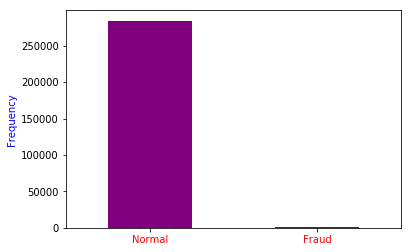

In [31]:
# Target
LABELS = ["Normal", "Fraud"]
credit.Class.value_counts().plot(kind = "bar", rot = 0, color = "purple")
plt.xticks(ticks = range(2), labels = LABELS, color = "red") # range 2 is for label count [Normal, Fraud]
plt.ylabel("Frequency", color = "blue")
plt.show()

Finding count of balanced and unbalanced class. The Positive class appears to be negligible in the above plot. Lets find the actual count

In [18]:
print("The Count of Genuine Class [No Fraud] is", credit.Class.value_counts()[0])
print("The Count of Positive Class [Fraud] is", credit.Class.value_counts()[1])

The Count of Genuine Class [No Fraud] is 284315
The Count of Positive Class [Fraud] is 492


### Lets Try to Build a Base Model 

In [36]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, matthews_corrcoef

In [33]:
x = credit.drop("Class", axis = 1)
y = credit.Class

In [46]:
xtrain, xtest,ytrain,ytest = train_test_split(x,y,test_size = 0.30, random_state = 1)

In [47]:
gbm = GradientBoostingClassifier()

In [48]:
#cross_val_score(estimator=gbm, X = x, y = y, cv = 5).mean()

In [49]:
pred = gbm.fit(xtrain,ytrain).predict(xtest)
print("Cohen's Kappa Score", cohen_kappa_score(ytest, pred))
print("Matthew's Correl Score", matthews_corrcoef(ytest, pred))

Cohen's Kappa Score 0.32532767125407747
Matthew's Correl Score 0.3801289251447112


In [50]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.67      0.21      0.33       135

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.84      0.61      0.66     85443
weighted avg       1.00      1.00      1.00     85443



### Lets Try Oversampling - SMOTE TOMEK

### What is SMOTE TOMEK

##### What are Tomek Links?

The Tomek Links algorithm removes data from the majority class that have tomek links. A tomek link is defined as data of different classes which are nearest neighbours of each other.

In other words, they are pairs of opposing instances that are very close together. Tomek’s algorithm looks for such pairs and removes the majority instance of the pair. The idea is to clarify the border between the minority and majority classes, making the minority region(s) more distinct.

Hence, SMOTE while applying over sampling of the minority class scans the data and removes the T-Links (Tomek Links) so that the region becomes clear between the minority and majority class making the minority region clear and hence it helps in increasing the samples of Minority class and also helps in defining decision boundary.

In [57]:
from imblearn.combine import SMOTETomek
from collections import Counter

In [53]:
# Implementing Oversampling for Handling Imbalanced 
smote = SMOTETomek(random_state=42)
X_res,y_res=smote.fit_sample(x,y)

In [54]:
X_res.shape,y_res.shape

((567562, 30), (567562,))

In [59]:
print("Original dataset shape {}".format(Counter(y)))
print("Resampled dataset shape {}".format(Counter(y_res)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 283781, 1: 283781})


In [60]:
xtrain, xtest,ytrain,ytest = train_test_split(X_res,y_res, test_size = 0.30, random_state = 10)

In [61]:
gbm1 = GradientBoostingClassifier()
pred1 = gbm1.fit(xtrain,ytrain).predict(xtest)
print("Cohen's Kappa Score", cohen_kappa_score(ytest, pred1))
print("Matthew's Correl Score", matthews_corrcoef(ytest, pred1))

Cohen's Kappa Score 0.9746633523182829
Matthew's Correl Score 0.9747546238852818


### Conclusion

1. The Base Model resulted a Kappa and Correl Score of 0.37 approx.

2. After the SMOTE Tomek, we see that the Kappa and Correl Score has become 0.97 and thus, we see that our model has really become a better model than the base.

### Simple SMOTE Model

In [64]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
sm_x, sm_y = sm.fit_sample(x,y)

In [65]:
print("Original dataset shape {}".format(Counter(y)))
print("Resampled dataset shape {}".format(Counter(sm_y)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 284315, 1: 284315})


In [66]:
xtrain, xtest,ytrain,ytest = train_test_split(sm_x,sm_y, test_size = 0.30, random_state = 10)

In [67]:
gbm2 = GradientBoostingClassifier()
pred2 = gbm2.fit(xtrain,ytrain).predict(xtest)
print("Cohen's Kappa Score", cohen_kappa_score(ytest, pred2))
print("Matthew's Correl Score", matthews_corrcoef(ytest, pred2))

Cohen's Kappa Score 0.9748990393835668
Matthew's Correl Score 0.9749773427990421


In [78]:
result = pd.DataFrame()

model1 = pd.Series({"Model": "GBM Base Model",
                   "Cohen's Kappa Score": cohen_kappa_score(ytest, pred),
                   "Mathew's Correlation": matthews_corrcoef(ytest, pred)})

model2 = pd.Series({"Model": "SMOTE TOMEK Model",
                   "Cohen's Kappa Score":cohen_kappa_score(ytest, pred1),
                   "Mathew's Correlation": matthews_corrcoef(ytest, pred1)})

model3 = pd.Series({"Model": "SMOTE Model",
                   "Cohen's Kappa Score":cohen_kappa_score(ytest, pred2),
                   "Mathew's Correlation":matthews_corrcoef(ytest, pred2)})

result.append([model1,model2,model3])

,Model,Cohen's Kappa Score,Mathew's Correlation
0,GBM Base Model,0.325328,0.380129
1,SMOTE Model,0.974899,0.974977
2,SMOTE TOMEK Model,0.974663,0.974755
